Solve Poisson equation using a mixed formulation.

The Poisson equation reads.
    \begin{equation}
        -\Delta u = f  \quad \text{in}\quad \Omega = [0,1]^2
    \end{equation}
In this notebook, we consider: (1) the boundary condition $u = u_{0}$ on the left and right edges $x = 0$ and $x = 1$ and (2) the boundary condition $\displaystyle \frac{\partial u}{\partial n} = g$ on the bottom and the top edges $y = 0$ and $y = 1$.

In [35]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt

In [36]:
# Create mesh
mesh = UnitSquareMesh(32, 32)

In [37]:
# Define function spaces and mixed (product) space
k_order = 3
BDM = FiniteElement("BDM", mesh.ufl_cell(), k_order)
DG = FiniteElement("DG", mesh.ufl_cell(), k_order-1)
W = FunctionSpace(mesh, MixedElement([BDM, DG]))

In [38]:
# Define trial and test functions
sigma, u = TrialFunctions(W)
tau,   v = TestFunctions(W)

In [39]:
# Define the source function
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02 )", degree=2)


In [40]:
# Define function G such that G \cdot n = g
class BoundarySource(UserExpression):
    def __init__(self, mesh, **kwargs):
        super().__init__()
        self.mesh = mesh
    def eval_cell(self, values, x, ufc_cell):
        cell = Cell(self.mesh, ufc_cell.index)
        n = cell.normal(ufc_cell.local_facet)
        g = sin(5*x[0])
        values[0] = g*n[0]
        values[1] = g*n[1]
    def value_shape(self):
        return (2,)
    
G = BoundarySource(mesh, degree=2)

In [41]:
# Define essential boundary
class BottomUpper(SubDomain):
    def inside(self, x, on_boundary):
        return bool((x[1] < DOLFIN_EPS or x[1] > (1.0 - DOLFIN_EPS)) 
                    and on_boundary)
bc = DirichletBC(W.sub(0), G, BottomUpper())

In [42]:
# Define variational form
a = (dot(sigma, tau) + div(tau)*u + div(sigma)*v)*dx
L = -f*v*dx

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


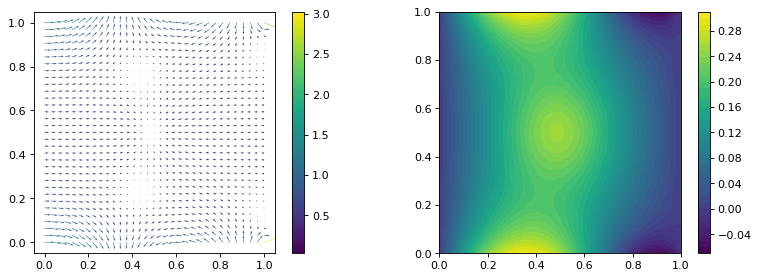

In [43]:
# Compute solution
w = Function(W)
solve(a == L, w, bc)
(sigma_sol, u_sol) = w.split()

plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(1,2,1)
p = plot(sigma_sol); plt.colorbar(p)
plt.subplot(1,2,2)
p = plot(u_sol); plt.colorbar(p)
plt.show()